# IMPORT THƯ VIỆN VÀ TẢI DATA

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from joblib import dump, load
from skimage.feature import local_binary_pattern
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [2]:
BASE_DIR = 'flowers'
CLASS_NAMES = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip', 'orchid', 'lily']
IMAGE_SIZE = (128, 128)
SNS_COLOR = sns.color_palette("viridis", len(CLASS_NAMES))

In [3]:
def collect_metadata(base_dir):
    data = {'subset': [], 'class_name': [], 'image_path': []}
    for subset in ['train', 'val', 'test']:
        subset_path = os.path.join(base_dir, subset)
        if not os.path.isdir(subset_path):
            continue

        for class_name in os.listdir(subset_path):
            class_path = os.path.join(subset_path, class_name)

            if os.path.isdir(class_path) and class_name in CLASS_NAMES:
                for image_file in os.listdir(class_path):
                    if image_file.endswith(('.jpg', '.jpeg', '.png')):
                        data['subset'].append(subset)
                        data['class_name'].append(class_name)
                        data['image_path'].append(os.path.join(class_path, image_file))

    return pd.DataFrame(data)

---EDA---
Total samples: 11531

Subset distribution:
  train: 8069 samples (69.98%)
  val: 2306 samples (20.00%)
  test: 1156 samples (10.03%)

Class distribution:
  daisy: 1759 samples (15.25%)
  dandelion: 1495 samples (12.97%)
  lily: 1618 samples (14.03%)
  orchid: 1851 samples (16.05%)
  rose: 1489 samples (12.91%)
  sunflower: 1713 samples (14.86%)
  tulip: 1606 samples (13.93%)


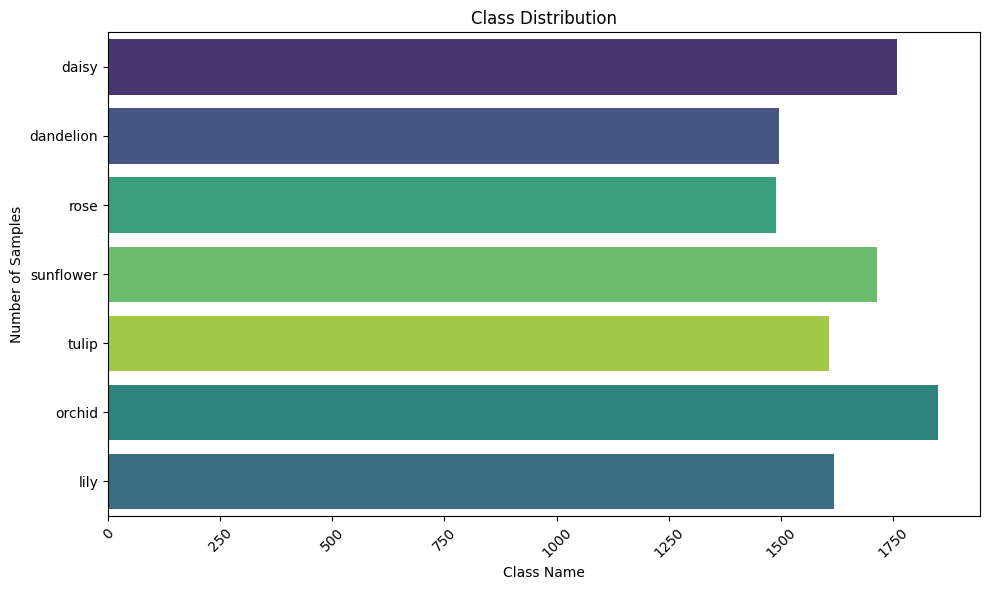

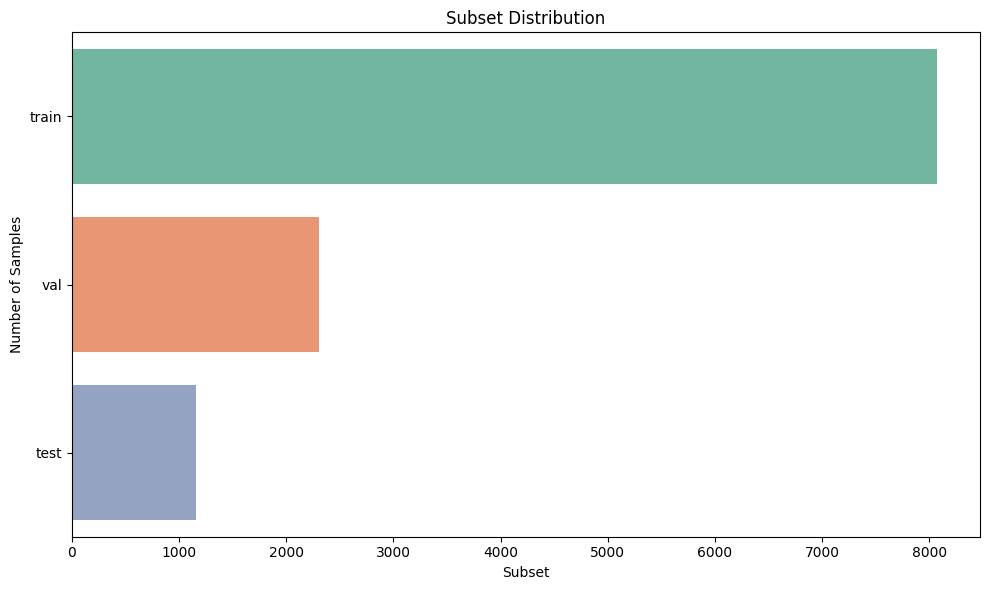


Class distribution across subsets:
subset      test  train  val  Train_Ratio
class_name                               
orchid       186   1295  370    69.962183
daisy        176   1231  352    69.982945
sunflower    172   1199  342    69.994162
lily         162   1132  324    69.962917
tulip        161   1124  321    69.987547
dandelion    150   1046  299    69.966555
rose         149   1042  298    69.979852


In [4]:
df = collect_metadata(BASE_DIR)

if df.empty:
    print("ERROR: No image data found. Please check the directory structure and file paths.")
else:
    print("---EDA---")
    total_samples = len(df)
    print(f"Total samples: {total_samples}")

    subset_counts = df['subset'].value_counts()
    subset_ratios = subset_counts / total_samples * 100
    print("\nSubset distribution:")
    for subset, count in subset_counts.items():
        ratio = subset_ratios[subset]
        print(f"  {subset}: {count} samples ({ratio:.2f}%)")

    class_counts = df['class_name'].value_counts().sort_index()
    print("\nClass distribution:")
    for class_name, count in class_counts.items():
        ratio = (count / total_samples) * 100
        print(f"  {class_name}: {count} samples ({ratio:.2f}%)")

    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, y='class_name', hue='class_name', order=CLASS_NAMES, palette=SNS_COLOR, legend=False)
    plt.title('Class Distribution')
    plt.xlabel('Class Name')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.countplot(data=df,y='subset', hue='subset', palette="Set2", legend=False)
    plt.title('Subset Distribution')
    plt.xlabel('Subset')    
    plt.ylabel('Number of Samples')
    plt.tight_layout()
    plt.show()

    class_subset_df = df.pivot_table(index='class_name', columns='subset', aggfunc='size', fill_value=0).reindex(CLASS_NAMES)
    class_subset_df['total'] = class_subset_df.sum(axis=1)
    class_subset_df['Train_Ratio'] = class_subset_df['train'] / class_subset_df['total'] * 100
    class_subset_df = class_subset_df.sort_values(by='total', ascending=False).drop(columns=['total'])

    print("\nClass distribution across subsets:")
    print(class_subset_df)

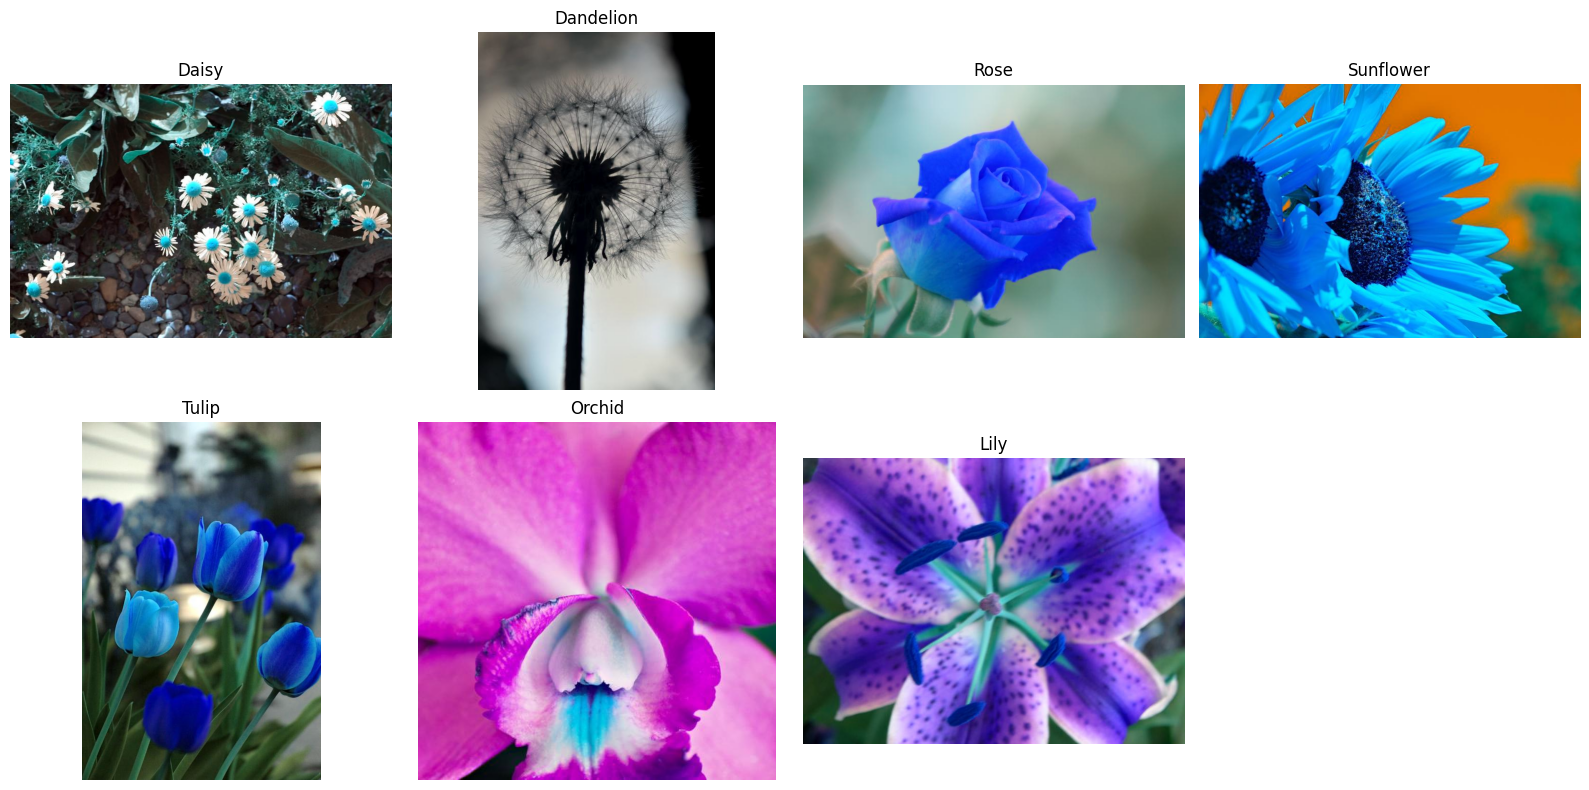

In [5]:
def display_sample_images(df, class_names, max_cols=4):
    sample_paths_df = df.groupby('class_name').head(1)
    num_classes = len(class_names)
    num_rows = int(np.ceil(num_classes / max_cols))
    plt.figure(figsize=(16, 4 * num_rows))
    
    for i, class_name in enumerate(class_names):
        plt.subplot(num_rows, max_cols, i + 1)
        sample_row = sample_paths_df[sample_paths_df['class_name'] == class_name]
        if not sample_row.empty:
            path = sample_row['image_path'].iloc[0] 
            try:
                img = cv2.imread(path)
                if img is None:
                    raise FileNotFoundError(f"Không thể tải ảnh. Đường dẫn có thể sai: {path}")
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.imshow(img)
                plt.title(f"{class_name.capitalize()}", fontsize=12)
                plt.axis('off')
            except Exception as e:
                plt.text(0.5, 0.5, f"Lỗi tải: {e}", ha='center', va='center', wrap=True)
                plt.title(f"{class_name.capitalize()} (Lỗi)", fontsize=12)
                plt.axis('off')
        else:
            plt.text(0.5, 0.5, "Không tìm thấy mẫu", ha='center', va='center')
            plt.title(f"{class_name.capitalize()}", fontsize=12)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

df = collect_metadata(BASE_DIR)
display_sample_images(df, CLASS_NAMES)

In [6]:
from sklearn.preprocessing import LabelEncoder

def preprocess_image(image_path, target_size, convert_to_grayscale=True):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError("ERROR: Image not found or unable to load.")
        return None
    
    # resize image to target size
    processed_image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
    # chuyển đổi sang ảnh xám
    if convert_to_grayscale:
        processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2GRAY)
    return processed_image

def demonstrate_resize_grayscale(image_path, target_size):
    original_image = cv2.imread(image_path)
    if original_image is None:
        print(f"Lỗi: Không thể đọc ảnh gốc tại {image_path}. Vui lòng kiểm tra đường dẫn.")
        return
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title('Ảnh Gốc (Màu)')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title('Ảnh Gốc Thứ 2 (Màu)')
    plt.axis('off')

    resized_image = cv2.resize(original_image, target_size, interpolation=cv2.INTER_AREA)
    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    plt.subplot(1, 3, 3)
    plt.imshow(grayscale_image, cmap='gray')
    plt.title(f'Sau Resize ({target_size}) & Grayscale')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return grayscale_image

In [7]:
def demonstrate_enhancement(image):
    print("\n--- 2. Minh Họa Tăng Cường Độ Tương Phản ---")

    if image is None: return

    # Cân bằng Histogram (Histogram Equalization)
    equalized_image = cv2.equalizeHist(image)

    # CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe_image = clahe.apply(image)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Ảnh Gốc (Grayscale)')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(equalized_image, cmap='gray')
    plt.title('Cân Bằng Histogram')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(clahe_image, cmap='gray')
    plt.title('CLAHE (Tăng cường thích ứng)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [8]:
def demonstrate_denoising(image):
    print("\n--- 3. Minh Họa Khử Nhiễu ---")

    if image is None: return

    # Tạo nhiễu giả để minh họa hiệu quả (Thêm nhiễu Salt-and-Pepper)
    noisy_image = np.copy(image)
    num_salt = np.ceil(0.01 * image.size)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    noisy_image[tuple(coords)] = 255 # Muối
    
    num_pepper = np.ceil(0.01 * image.size)
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    noisy_image[tuple(coords)] = 0   # Hạt tiêu

    # Áp dụng bộ lọc Gaussian
    gaussian_blur = cv2.GaussianBlur(noisy_image, (5, 5), 0)

    # Áp dụng bộ lọc Trung vị (Median Filter)
    median_blur = cv2.medianBlur(noisy_image, 5)

    plt.figure(figsize=(18, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Ảnh Gốc (Grayscale)')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(noisy_image, cmap='gray')
    plt.title('Ảnh Có Nhiễu (Salt & Pepper)')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(gaussian_blur, cmap='gray')
    plt.title('Khử Nhiễu bằng Gaussian Blur')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(median_blur, cmap='gray')
    plt.title('Khử Nhiễu bằng Median Filter')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [9]:
def demonstrate_data_augmentation(image_path, target_size):
    print("\n--- 4. Minh Họa Tăng Cường Dữ Liệu (Data Augmentation) ---")

    original_image = cv2.imread(image_path)
    if original_image is None:
        print(f"Lỗi: Không thể đọc ảnh gốc tại {image_path}. Vui lòng kiểm tra đường dẫn.")
        return

    # Chuẩn bị ảnh gốc đã resize (để các phép augmentation nhất quán)
    base_image = cv2.resize(original_image, target_size, interpolation=cv2.INTER_AREA)
    base_image_rgb = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB)

    augmented_images = []
    titles = []

    # Xoay (Rotation)
    angle = random.randint(-15, 15)
    (h, w) = base_image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(base_image_rgb, M, (w, h))
    augmented_images.append(rotated)
    titles.append(f'Xoay ({angle}°)')

    # Lật ngang (Horizontal Flip)
    flipped = cv2.flip(base_image_rgb, 1) # 1 cho lật ngang, 0 cho lật dọc
    augmented_images.append(flipped)
    titles.append('Lật Ngang')

    # Thay đổi độ sáng (Brightness Adjustment)
    # Tăng độ sáng (ví dụ: +50)
    brightness_factor = random.uniform(0.7, 1.3) # Giảm/tăng 30% độ sáng
    brightened = cv2.convertScaleAbs(base_image, alpha=brightness_factor, beta=0)
    brightened_rgb = cv2.cvtColor(brightened, cv2.COLOR_BGR2RGB) # Chuyển lại nếu base_image là BGR
    augmented_images.append(brightened_rgb)
    titles.append(f'Độ sáng x{brightness_factor:.1f}')
    
    # Zoom (Phóng to/Thu nhỏ)
    scale = random.uniform(0.8, 1.2) # Phóng to/thu nhỏ 20%
    zoomed = cv2.resize(base_image_rgb, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
    # Cần cắt hoặc thêm pad nếu kích thước thay đổi
    if scale < 1.0: # Nếu thu nhỏ, thêm border
        top = (h - zoomed.shape[0]) // 2
        bottom = h - zoomed.shape[0] - top
        left = (w - zoomed.shape[1]) // 2
        right = w - zoomed.shape[1] - left
        zoomed = cv2.copyMakeBorder(zoomed, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0,0,0])
    elif scale > 1.0: # Nếu phóng to, cắt phần trung tâm
        start_row = (zoomed.shape[0] - h) // 2
        end_row = start_row + h
        start_col = (zoomed.shape[1] - w) // 2
        end_col = start_col + w
        zoomed = zoomed[start_row:end_row, start_col:end_col]
        
    augmented_images.append(zoomed)
    titles.append(f'Phóng to x{scale:.1f}')

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 5, 1)
    plt.imshow(base_image_rgb)
    plt.title('Ảnh Gốc (Sau Resize)')
    plt.axis('off')

    for i in range(len(augmented_images)):
        plt.subplot(1, 5, i + 2)
        plt.imshow(augmented_images[i])
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [10]:
def demonstrate_resize_grayscale(image_path, target_size):
    original_image = cv2.imread(image_path)
    if original_image is None:
        print(f"Lỗi: Không thể đọc ảnh gốc tại {image_path}. Vui lòng kiểm tra đường dẫn.")
        return
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title('Ảnh Gốc (Màu)')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title('Ảnh Gốc Thứ 2 (Màu)')
    plt.axis('off')

    resized_image = cv2.resize(original_image, target_size, interpolation=cv2.INTER_AREA)
    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    plt.subplot(1, 3, 3)
    plt.imshow(grayscale_image, cmap='gray')
    plt.title(f'Sau Resize ({target_size}) & Grayscale')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return grayscale_image

In [11]:
import random

if __name__ == '__main__':
    # Kiểm tra xem đường dẫn ảnh mẫu có hợp lệ không
    random_path = random.choice(df['image_path'].tolist())
    if not os.path.exists(random_path):
        print(f"Lỗi: Không tìm thấy file ảnh mẫu tại {random_path}.")
        print("Vui lòng cập nhật biến SAMPLE_IMAGE_PATH để trỏ đến một ảnh hợp lệ trong dataset của bạn.")
    else:
        # Bước 1: Minh họa Resize và Grayscale
        grayscale_img_resized = demonstrate_resize_grayscale(random_path, TARGET_SIZE)
        
        # Các bước tiếp theo cần ảnh grayscale đã resize
        if grayscale_img_resized is not None:
            # Bước 2: Tăng cường Độ tương phản và Ánh sáng
            demonstrate_enhancement(grayscale_img_resized)

            # Bước 3: Khử nhiễu
            demonstrate_denoising(grayscale_img_resized)
        
        # Bước 4: Tăng cường Dữ liệu (thực hiện trên ảnh màu đã resize để có hiệu ứng rõ hơn)
        demonstrate_data_augmentation(random_path, IMAGE_SIZE)

NameError: name 'TARGET_SIZE' is not defined